# Constrained Shape Optimization

In [1]:
# !pip install ngsolve --upgrade
# !pip install webgui_jupyter_widgets --upgrade
# !pip install matplotlib --upgrade

from shapeOptInductor import create_plots, update_plots, rot
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt


## 1 - Meshing

In [2]:
from netgen.geom2d import SplineGeometry


thickness = 1e-2


def gen_mesh(air_gap=4e-3, maxh=2e-3):
    """Gives a triangular mesh"""
    # Global domain
    r = 0.04

    # Geometry definition
    e = 5e-3
    a = 1e-2
    ha = 1e-2
    ba = 1e-2
    geo = SplineGeometry()
    pnts = [
        (0, air_gap / 2),  # p1
        (a / 2, air_gap / 2),  # p2
        (a / 2, e / 2 + ha / 2),  # p3
        (a / 2 + ba, e / 2 + ha / 2),  # p4
        (a / 2 + ba, air_gap / 2),  # p5
        (a + ba, air_gap / 2),  # p6
        (a + ba, e / 2 + ha / 2 + a / 2),  # p7
        (0, e / 2 + ha / 2 + a / 2),  # p8
        (a + ba, 0),  # p001
        (a + ba, e / 2 + ha / 2),  # p002
        (0, e / 2 + ha / 2),  # p003
        (0, 0),  # p00
        (r, 0),  # p01
        (0, r),  # p02
        (a / 2, 0),  # p03
        (a / 2 + ba, 0),  # p04
        (r, r),  # p05
    ]

    (
        p1,
        p2,
        p3,
        p4,
        p5,
        p6,
        p7,
        p8,
        p001,
        p002,
        p003,
        p00,
        p01,
        p02,
        p03,
        p04,
        p05,
    ) = [geo.AppendPoint(*pnt) for pnt in pnts]

    # List of lines with boundary conditions and domains
    lines = [
        [["line", p1, p2], {"bc": "front", "leftdomain": 5, "rightdomain": 6}],
        [["line", p2, p3], {"bc": "optimVert", "leftdomain": 5, "rightdomain": 3}],
        [["line", p3, p4], {"bc": "default", "leftdomain": 2, "rightdomain": 3}],
        [["line", p4, p5], {"bc": "optimVert", "leftdomain": 4, "rightdomain": 3}],
        [["line", p5, p6], {"bc": "front", "leftdomain": 4, "rightdomain": 7}],
        [["line", p6, p002], {"bc": "optimVert", "leftdomain": 4, "rightdomain": 1}],
        [["line", p002, p7], {"bc": "default", "leftdomain": 2, "rightdomain": 1}],
        [["line", p7, p8], {"bc": "default", "leftdomain": 2, "rightdomain": 1}],
        [["line", p00, p03], {"bc": "domainHor", "leftdomain": 6, "rightdomain": 0}],
        [["line", p03, p04], {"bc": "segment1", "leftdomain": 3, "rightdomain": 0}],
        [["line", p04, p001], {"bc": "domainHor", "leftdomain": 7, "rightdomain": 0}],
        [["line", p001, p01], {"bc": "segment1", "leftdomain": 1, "rightdomain": 0}],
        [["line", p02, p8], {"bc": "segment2", "leftdomain": 1, "rightdomain": 0}],
        [["line", p8, p003], {"bc": "segment2", "leftdomain": 2, "rightdomain": 0}],
        [["line", p003, p1], {"bc": "domainVert", "leftdomain": 5, "rightdomain": 0}],
        [["line", p1, p00], {"bc": "domainVert", "leftdomain": 6, "rightdomain": 0}],
        [["line", p001, p6], {"bc": "optimVert", "leftdomain": 7, "rightdomain": 1}],
        [["line", p04, p5], {"bc": "optimVert", "leftdomain": 3, "rightdomain": 7}],
        [["line", p2, p03], {"bc": "optimVert", "leftdomain": 3, "rightdomain": 6}],
        [["line", p3, p003], {"bc": "optimHor", "leftdomain": 5, "rightdomain": 2}],
        [["line", p002, p4], {"bc": "optimHor", "leftdomain": 4, "rightdomain": 2}],
        [["spline3", p01, p05, p02], {"bc": "arc", "leftdomain": 1, "rightdomain": 0}],
    ]

    # Append all lines to the geometry
    for line, props in lines:
        geo.Append(line, **props)

    # Set materials and meshing parameters
    geo.SetMaterial(1, "air")
    geo.SetMaterial(2, "core")
    geo.SetMaterial(3, "coil")
    geo.SetMaterial(4, "core")
    geo.SetMaterial(5, "core")
    geo.SetMaterial(6, "air")
    geo.SetMaterial(7, "air")
    ngmesh = geo.GenerateMesh(maxh=maxh)
    return ngs.Mesh(ngmesh)


mesh = gen_mesh(air_gap=4e-3, maxh=1e-3)
XiAir = mesh.MaterialCF({"air": 1})
XiCore = mesh.MaterialCF({"core": 1})
XiCoil = mesh.MaterialCF({"coil": 1})

Draw(1 * XiAir + 2 * XiCoil + 3 * XiCore, mesh, radius=0.02)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 2 - Computation of magnetic state

In [3]:
# Frequency
f = 5e4  # Hz
omega = 2 * np.pi * f

# Magnetic
mu0 = 4e-7 * np.pi
mur = 1000
mu_iron = mur * mu0
delta = 0.1
mu_coil = np.exp(-1j * delta) * mu0  #  AC losses in the copper from the imaginary part of the permeability

# Current
nb_turn = 200  # Number of turn in the coil
Is = 2  # Source current intensity
js = nb_turn / 2 * Is / (ngs.Integrate(XiCoil, mesh)) * XiCoil  # Source current density


def magWeakFormComplex(a, a_):
    bf = ngs.grad(a_) * 1 / mu_iron * ngs.grad(a) * ngs.dx("core")
    bf += ngs.grad(a_) * 1 / mu_coil * ngs.grad(a) * ngs.dx("coil")
    bf += ngs.grad(a_) * 1 / mu0 * ngs.grad(a) * ngs.dx("air")
    lf = a_ * js * ngs.dx("coil")
    return bf, lf


def solveStateComplex(fes):
    a, a_ = fes.TnT()
    bf, f = magWeakFormComplex(a, a_)
    K, F = ngs.BilinearForm(fes), ngs.LinearForm(fes)
    K += bf
    F += f
    K.Assemble()
    F.Assemble()
    gf = ngs.GridFunction(fes)
    Kinv = K.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")  # Hermitian ?
    gf.vec.data = Kinv * F.vec
    return gf, Kinv


fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
state, Kinv = solveStateComplex(fes)
Draw(ngs.Norm(state), mesh, radius=0.02)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [4]:
def Inductance(a, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return 2 * 4 * thickness / (2 * Is**2) * ngs.Integrate(rel.real * ngs.Norm(ngs.grad(a)) ** 2, mesh)


def Losses(a, mesh):
    rel = XiCoil / mu_coil
    return 4 * omega / 2 * thickness * ngs.Integrate(rel.imag * ngs.Norm(ngs.grad(a)) ** 2, mesh)


# For the augmented lagrangian
L_target = 1e-3


def Constraint(a, mesh):
    return Inductance(a, mesh) - L_target


def CostFunction(a, l, b, constraint, mesh):
    return (Losses(a, mesh) + l * constraint + 0.5 * b * constraint**2).real


In [5]:
fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
state, Kinv = solveStateComplex(fes)

print(f"The inductance is {1e3 * np.absolute(Inductance(state, mesh)):.3f} mH")
print(f"The losses amounts to {Losses(state, mesh):.3f} W")

# Draw(state, radius=0.02)
# Draw(ngs.Norm(rot(state)), mesh, radius=0.02)


The inductance is 1.005 mH
The losses amounts to 12.406 W


In [6]:
def solveAdjointLosses(a0, Kinv):
    """Solves the adjoint equation for the losses inside the coil"""
    fes = a0.space
    p, p_ = fes.TnT()
    F = ngs.LinearForm(fes)
    coeff_losses = 4 * omega / 2 * thickness * (XiCoil / mu_coil).imag
    F += -2 * coeff_losses * ngs.InnerProduct(ngs.grad(a0), ngs.grad(p_)) * ngs.dx("coil")
    F.Assemble()
    gf = ngs.GridFunction(fes)
    gf.vec.data = Kinv.H * F.vec
    return gf


def solveAdjointInductance(a0, Kinv):
    """Solves the adjoint equation for the inductance"""
    fes = a0.space
    p, p_ = fes.TnT()
    F = ngs.LinearForm(fes)
    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    coeff_induc = 2 * 4 * thickness / (2 * Is**2) * rel
    F += -2 * coeff_induc * ngs.InnerProduct(ngs.grad(a0), ngs.grad(p_)) * ngs.dx
    F.Assemble()
    gf = ngs.GridFunction(fes)
    gf.vec.data = Kinv * F.vec
    return gf


def computeLossesShapeDerivative(VEC_complex, VEC_real, a0, p0):
    """Shape derivative for the energy-based losses inside the coil"""
    X = VEC_complex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix
    coeff_losses = 4 * omega / 2 * thickness * (XiCoil / mu_coil).imag
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(VEC_complex)
    dLOmega += coeff_losses * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx("coil")
    dLOmega += -js * XiCoil * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx

    dLOmega.Assemble()
    dJ = ngs.GridFunction(VEC_real)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ


def computeInductanceShapeDerivative(VEC_complex, VEC_real, a0, p0):
    """Shape derivative for the inductance"""
    X = VEC_complex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix
    coeff_induc = 2 * 4 * thickness / (2 * Is**2) * rel
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(VEC_complex)
    dLOmega += coeff_induc * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx
    dLOmega += -js * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx
    dLOmega.Assemble()

    dJ = ngs.GridFunction(VEC_real)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ


def computeShapeDerivative(mesh, VEC_complex, VEC_real, state, adjoint_losses, adjoint_inductance, l, b):
    """Shape derivative for the cost function"""
    dJOmegaInductance = computeInductanceShapeDerivative(VEC_complex, VEC_real, state, adjoint_inductance)
    constraint = Constraint(state, mesh)
    dJOmega = computeLossesShapeDerivative(VEC_complex, VEC_real, state, adjoint_losses)
    dJOmega.vec.FV().NumPy()[:] += l * dJOmegaInductance.vec.FV().NumPy()[:]
    dJOmega.vec.FV().NumPy()[:] += b * constraint * dJOmegaInductance.vec.FV().NumPy()[:]
    return dJOmega


In [7]:
mesh = gen_mesh(air_gap=4e-3, maxh=5e-4)

fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
VEC_complex = ngs.VectorH1(mesh, complex=True)
VEC_real = ngs.VectorH1(mesh)

state, Kinv = solveStateComplex(fes)  # Is a GridFunction (field approximated on a fes)
adjoint_losses = solveAdjointLosses(state, Kinv)
adjoint_inductance = solveAdjointInductance(state, Kinv)

dJOmega = computeShapeDerivative(mesh, VEC_complex, VEC_real, state, adjoint_losses, adjoint_inductance, 1, 1)

Draw(adjoint_inductance, radius=0.02)
Draw(adjoint_losses.real, mesh, radius=0.02)  # Note that the imag part should be 0


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

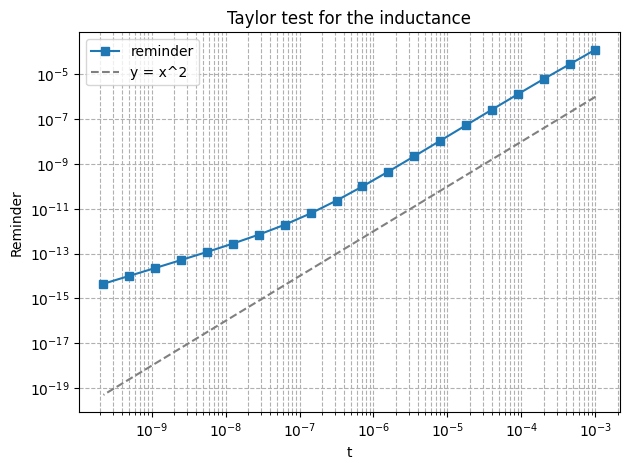

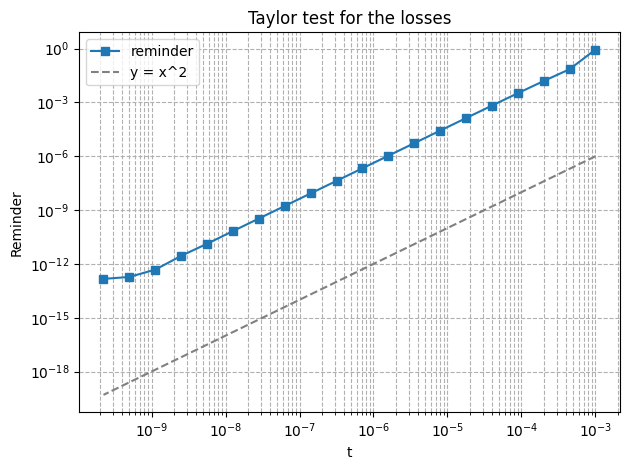

In [8]:
from mmglib import copy_ngmesh


def TaylorTest(cost, compute_adjoint, compute_shape_derivative, title="Taylor test"):
    mesh = gen_mesh(air_gap=4e-3, maxh=1e-3)
    fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
    VEC_complex = ngs.VectorH1(mesh, complex=True)
    VEC_real = ngs.VectorH1(mesh)
    a0, Kinv = solveStateComplex(fes)
    p0 = compute_adjoint(a0, Kinv)
    dJOmega = compute_shape_derivative(VEC_complex, VEC_real, a0, p0)

    direction = ngs.GridFunction(VEC_real)
    direction.Set(ngs.CF((0, 1)), definedon=mesh.Boundaries("front"))

    nb_sample = 20
    exponent_min = 3
    exponent_max = 10

    reminders = []

    X = []

    meshT = ngs.Mesh(copy_ngmesh(mesh.ngmesh))  # For transported mesh
    fesT = ngs.H1(meshT, order=1, dirichlet="arc|segment2|domainVert", complex=True)
    # VEC_complexT = ngs.VectorH1(meshT, complex=True)
    VEC_realT = ngs.VectorH1(meshT)

    for i in range(nb_sample):
        # Abscissa axis in log scale
        t = 10 ** (-(i / nb_sample * (exponent_max - exponent_min) + exponent_min))
        X.append(t)

        # Finite difference
        displacement = ngs.GridFunction(VEC_realT)
        displacement.Set(t * ngs.CF((0, 1)), definedon=mesh.Boundaries("front"))
        meshT.SetDeformation(displacement)
        aT, _ = solveStateComplex(fesT)
        difference = cost(aT, meshT) - cost(a0, mesh)

        # Reminder for analytic shape derivative
        reminder_value = np.abs(difference - ngs.InnerProduct(dJOmega.vec, t * direction.vec))
        reminders.append(reminder_value)

    Y = np.power(np.array(X), 2)
    fig, ax = plt.subplots(1, 1)

    ax.plot(X, reminders, label="reminder", marker="s")
    ax.plot(X, Y, label="y = x^2", linestyle="--", color="gray")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("t")
    ax.set_ylabel("Reminder")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()


TaylorTest(Inductance, solveAdjointInductance, computeInductanceShapeDerivative, title="Taylor test for the inductance")
TaylorTest(Losses, solveAdjointLosses, computeLossesShapeDerivative, title="Taylor test for the losses")


## 4 - Computation of the descent direction

In [9]:
def SolveDeformationEquation(mesh, fX):
    VEC = ngs.VectorH1(
        mesh,
        order=1,
        dirichlet="arc|segment1|segment2|default",
        dirichlety="optimHor|domainHor",
        dirichletx="optimVert|domainVert",
    )
    PHI, X = VEC.TnT()

    # H1 dot product
    B = ngs.BilinearForm(VEC)
    B += ngs.InnerProduct(ngs.grad(X), ngs.grad(PHI)) * ngs.dx + ngs.InnerProduct(X, PHI) * ngs.dx
    B.Assemble()

    gfX = ngs.GridFunction(VEC)
    gfX.vec.data = -B.mat.Inverse(VEC.FreeDofs()) * fX.vec
    return gfX


# Without dirichlet conditions
dJ = ngs.GridFunction(VEC_real)
dJ.vec.FV().NumPy()[:] = dJOmega.vec.FV().NumPy()[:]
Draw(dJ, mesh, vectors={"grid_size": 40}, radius=0.02)

# With dirichlet conditions
descent_direction = SolveDeformationEquation(mesh, dJ)
Draw(descent_direction.real, mesh, vectors={"grid_size": 40}, radius=0.02)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 5 - Testing mesh adaptation with mmg

In [10]:
# Initializations
mesh = gen_mesh(air_gap=4e-3, maxh=7e-4)
fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
VEC_complex = ngs.VectorH1(mesh, complex=True)
VEC_real = ngs.VectorH1(mesh)

l = 1e-2
b = 1e-1

# State and cost function
state, Kinv = solveStateComplex(fes)
constraint = Constraint(state, mesh)
Jold = CostFunction(state, l, b, constraint, mesh)

# Adjoints, shape derivate then descent direction
adjoint_losses = solveAdjointLosses(state, Kinv)
adjoint_inductance = solveAdjointInductance(state, Kinv)
dJOmega = computeShapeDerivative(mesh, VEC_complex, VEC_real, state, adjoint_losses, adjoint_inductance, 1, 1)

descent_direction = SolveDeformationEquation(mesh, dJOmega)
currentNorm = ngs.Norm(descent_direction.vec)
derivative = ngs.InnerProduct(dJOmega.vec, descent_direction.vec)

if derivative > 0:
    raise ValueError("derivative positive :(")


def move_ngmesh_2D(displ, mesh):
    mat_displ = displ.vec.FV().NumPy()
    nb_points = len(mat_displ) // 2
    for i, point in enumerate(mesh.ngmesh.Points()):
        vx = mat_displ[i]
        vy = mat_displ[i + nb_points]
        point[0] += vx
        point[1] += vy
    mesh.ngmesh.Update()


from mmglib import run_adapt, copy_ngmesh

# print("Initial mesh")
# state, Kinv = solveStateComplex(fes)
# Draw(ngs.Norm(rot(state)), mesh)

# print("copy of Initial mesh")
# copied_ngmesh = copy_ngmesh(mesh.ngmesh)
# copied_mesh = ngs.Mesh(copied_ngmesh)
# Draw(ngs.Norm(rot(state)), copied_mesh)

print("Moved mesh")
descent_direction.vec.data = 1e-7 * descent_direction.vec
move_ngmesh_2D(descent_direction, mesh)
# mesh.ngmesh.OptimizeMesh2d() # Does not work

# Test the descent of the cost
fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
state, Kinv = solveStateComplex(fes)
constraint = Constraint(state, mesh)
Jnew = CostFunction(state, l, b, constraint, mesh)

if Jnew < Jold:
    print("J decreased")
else:
    print("J increased")
Draw(ngs.Norm(rot(state)), mesh)

# print("copy of Initial mesh")
# Draw(ngs.Norm(rot(state)), copied_mesh)

print("Optimized moved mesh")
new_ngmesh, return_code = run_adapt(mesh.ngmesh, hausd=3e-6, hmax=2e-3)
new_mesh = ngs.Mesh(new_ngmesh)
fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
state, Kinv = solveStateComplex(fes)
Draw(ngs.Norm(rot(state)), new_mesh)

# print("Recover initial mesh")
# descent_direction.vec.data = -descent_direction.vec
# move_ngmesh_2D(descent_direction, mesh)
# fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
# state, tangent_matrix = solveStateComplex(fes)
# Draw(ngs.Norm(rot(state)), mesh)


Moved mesh
J decreased


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Optimized moved mesh


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 4 - Optimization loop


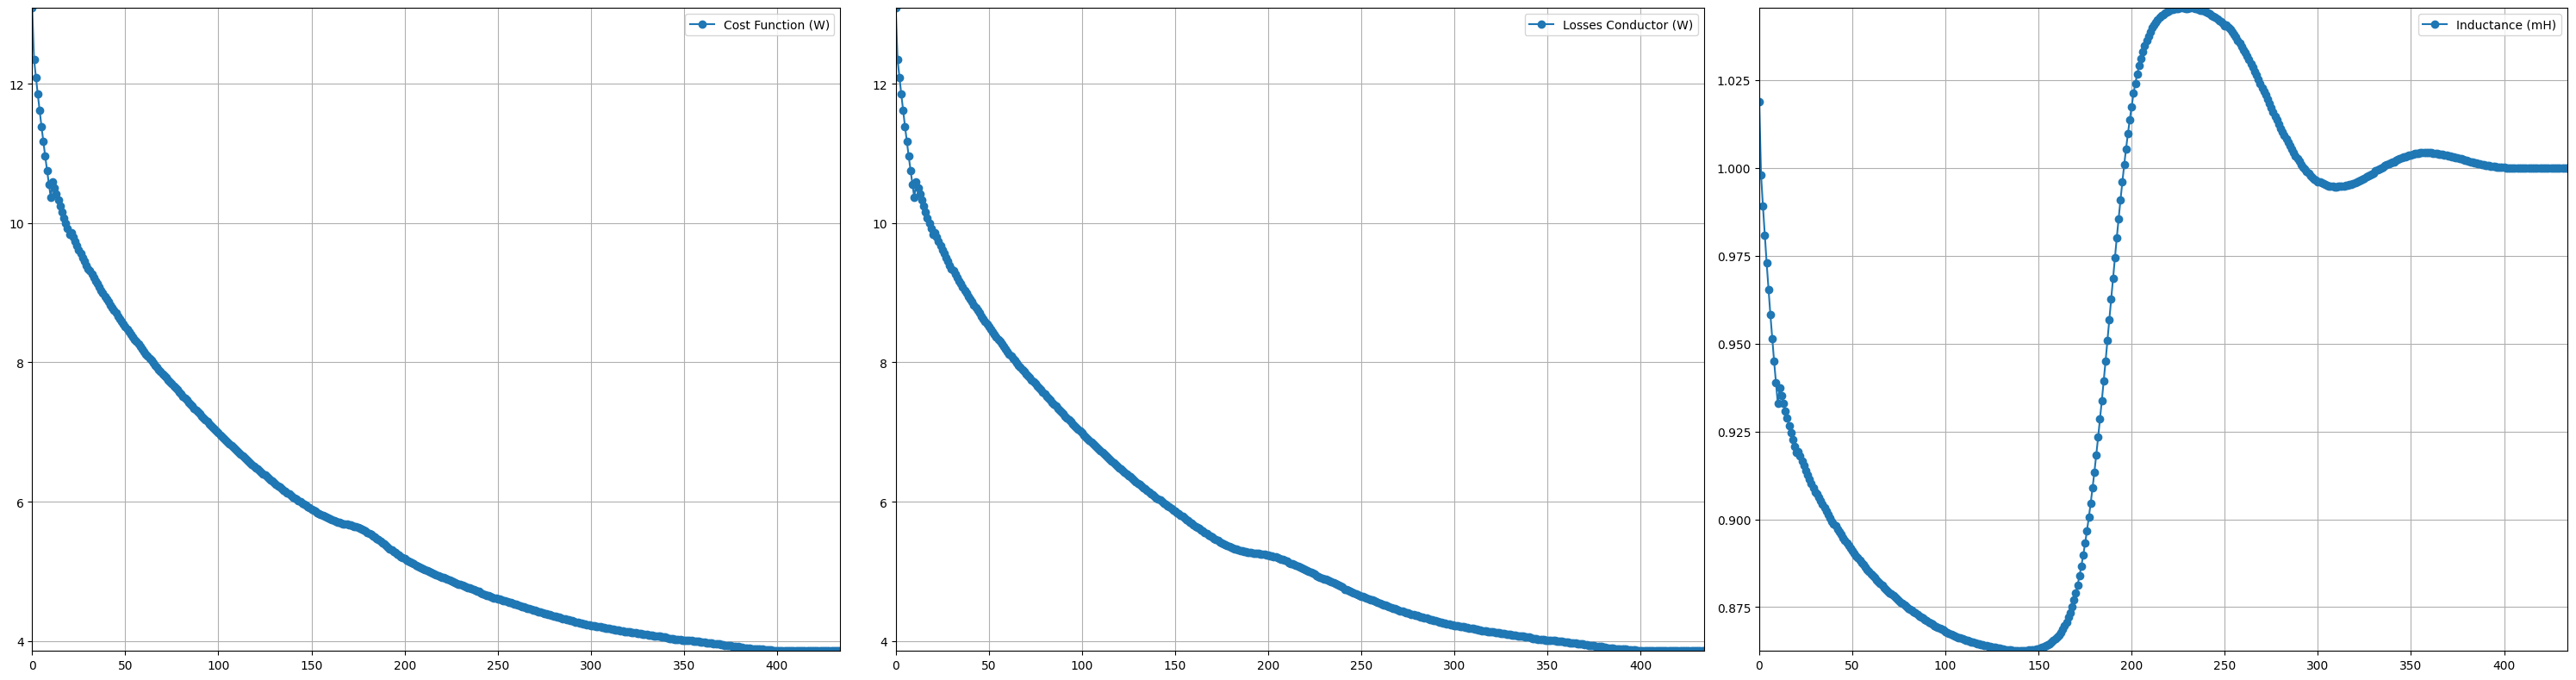

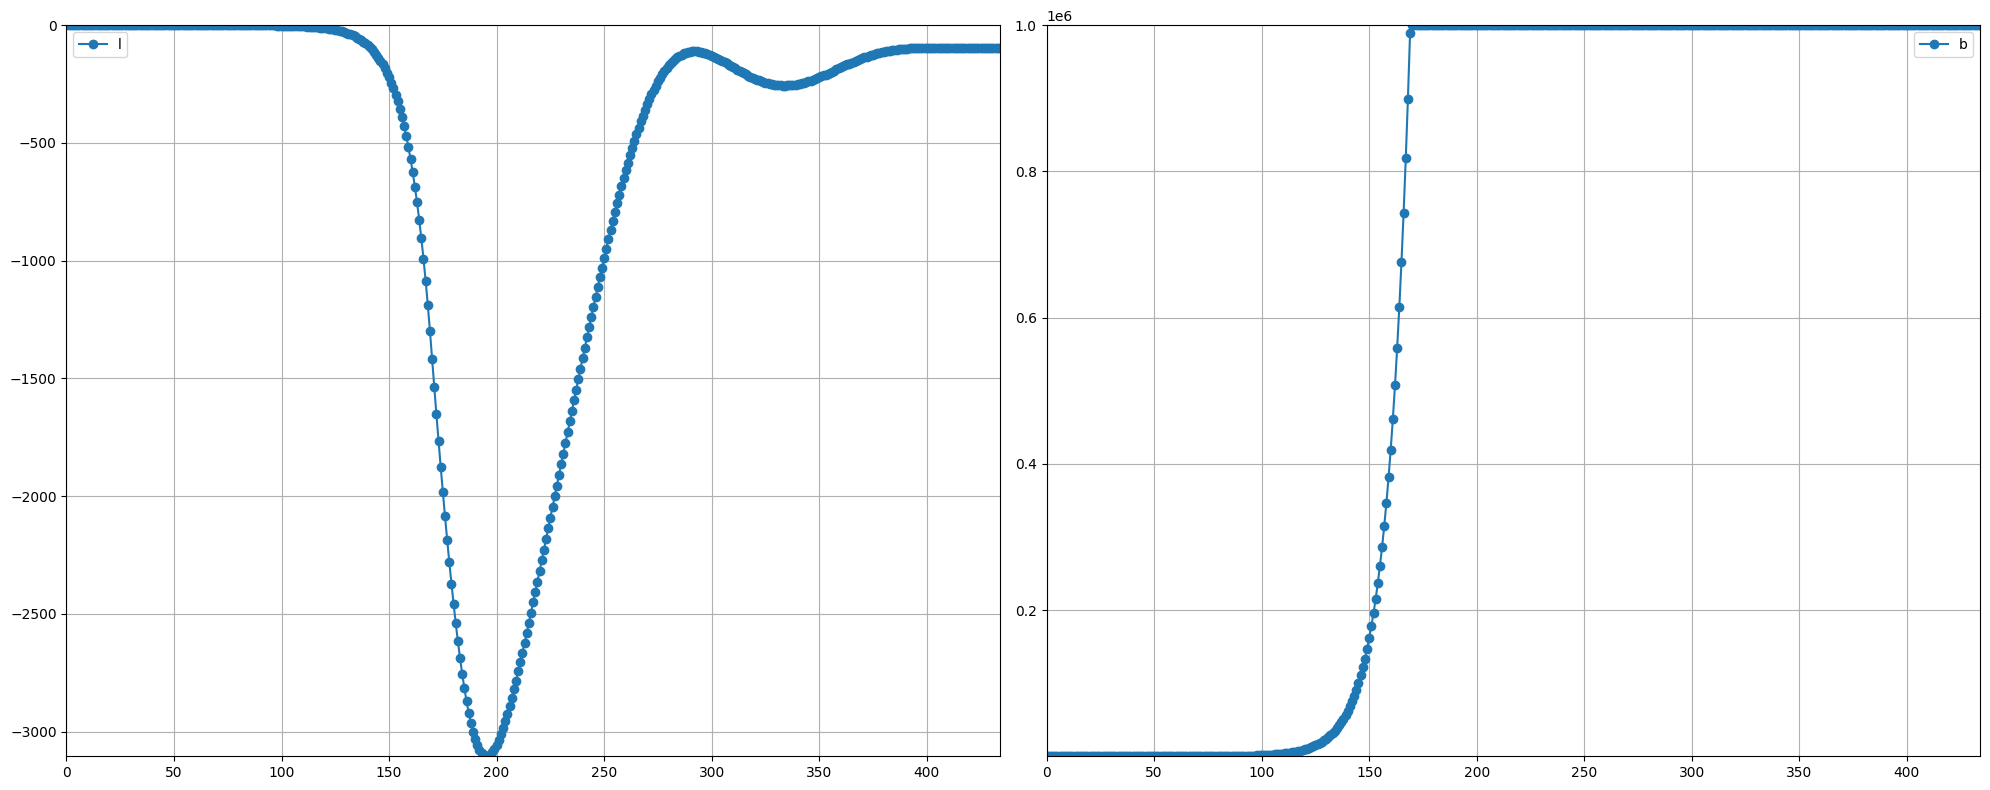

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

d:\ricam\temp\inductance-compumag\notebooks\shapeOptInductor.py:500: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, len(curve) - 1)
d:\ricam\temp\inductance-compumag\notebooks\shapeOptInductor.py:503: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(min_y, max_y)


Inductance crossed 1mH iter=196 inductance=1.000866325488558 mH losses=5.252038581086915 W
Inductance crossed 1mH iter=293 inductance=0.9996120984459876 mH losses=4.266448949103776 W
Inductance crossed 1mH iter=334 inductance=1.0000067649522997 mH losses=4.078218881685103 W
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search fail
Line search

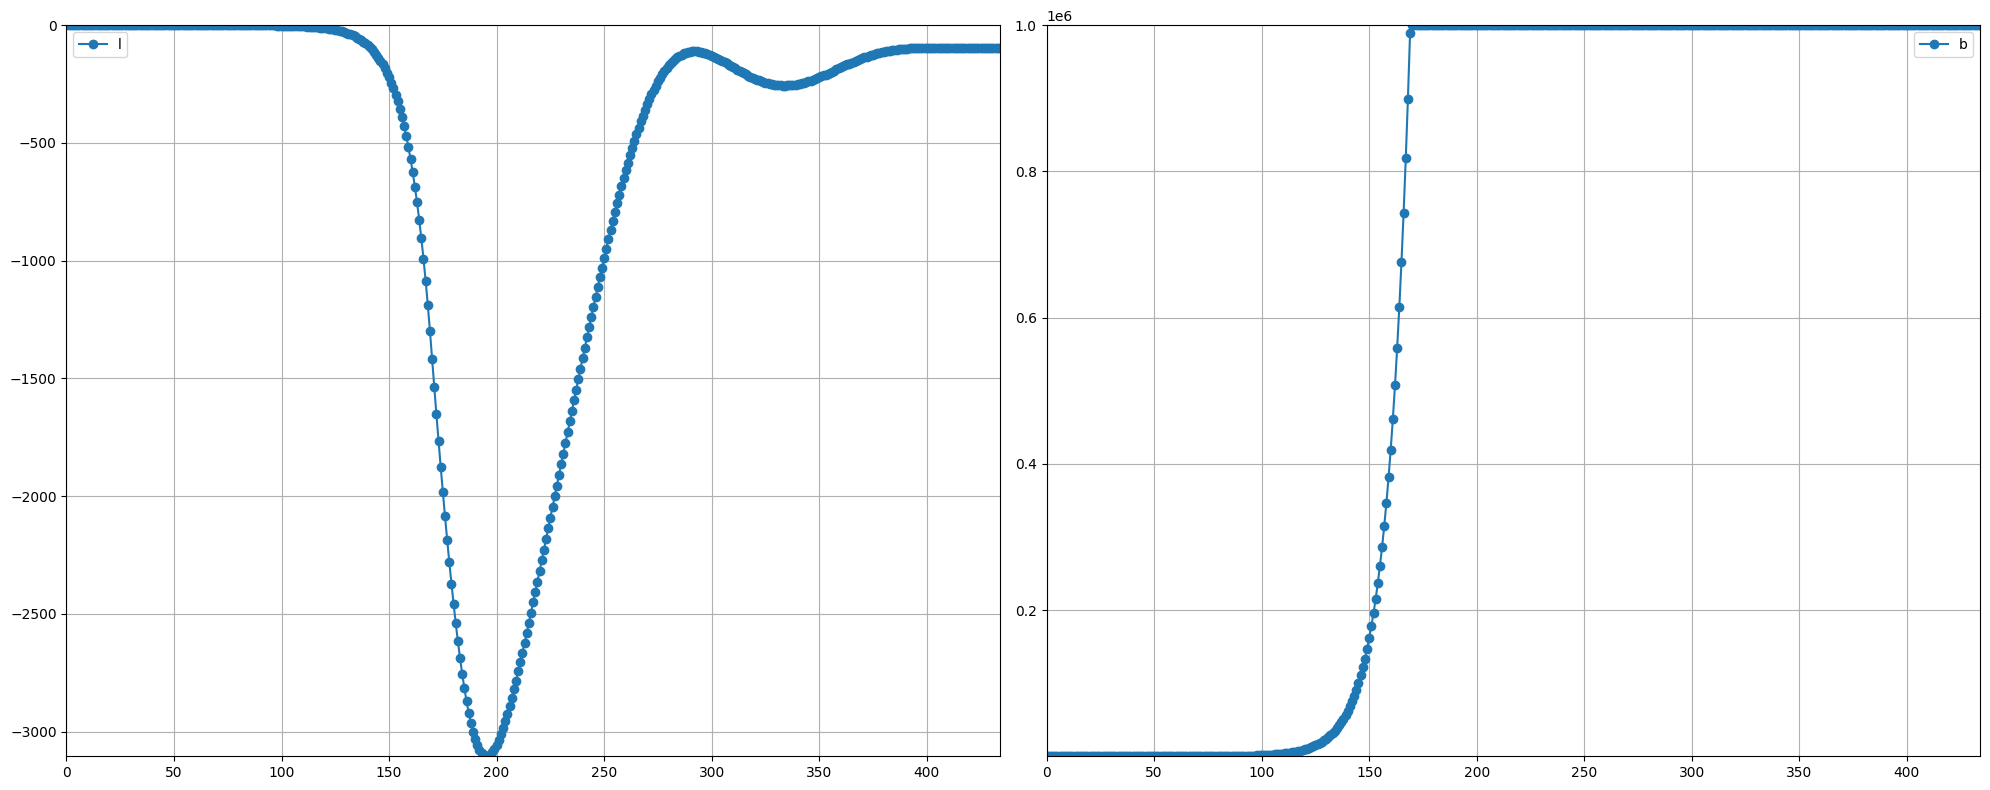

In [11]:
# Initialize geometry
maxh = 5e-4
mesh = gen_mesh(air_gap=4e-3, maxh=5e-4)

fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
VEC_complex = ngs.VectorH1(mesh, order=1, complex=True)
VEC_real = ngs.VectorH1(mesh, order=1)

# Initialize data arrays and plots
cost_values = []
losses_values = []
inductance_values = []
num_plots = 3
fig, axes, hdisplay = create_plots(num_plots)
curve_labels = [
    ["Cost Function (W)"],
    ["Losses Conductor (W)"],
    ["Inductance (mH)"],
]

l_values = []
b_values = []
num_plots = 2
figBis, axesBis, hdisplayBis = create_plots(num_plots)
curve_labels_bis = [
    ["l"],
    ["b"],
]

scene = Draw(ngs.Norm(rot(state)), mesh, radius=0.02)

# Algorithmic parameters
iter_max = 1000
converged = False
iter = 0
minstep = 1e-11
maxstep = 0.5
step = maxstep
eps = 1e-10
export_count = 0

# Augmented Lagragian parameters
l = 1e-2
b = 1e-1
btarget = 1e6

# Initializing state, adjoints, cost function
state, Kinv = solveStateComplex(fes)
adjoint_losses = solveAdjointLosses(state, Kinv)
adjoint_inductance = solveAdjointInductance(state, Kinv)
dJOmega = computeShapeDerivative(mesh, VEC_complex, VEC_real, state, adjoint_losses, adjoint_inductance, l, b)
constraint = Constraint(state, mesh)
Jnew = CostFunction(state, l, b, constraint, mesh)


# Optimization loop
while not converged and iter < iter_max:
    # Step 1: Update fe spaces
    fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
    VEC_complex = ngs.VectorH1(mesh, order=1, complex=True)
    VEC_real = ngs.VectorH1(mesh, order=1)

    # Step 2: Update the state and adjoint state
    state, Kinv = solveStateComplex(fes)
    adjoint_losses = solveAdjointLosses(state, Kinv)
    adjoint_inductance = solveAdjointInductance(state, Kinv)

    constraintold = Constraint(state, mesh)
    Jold = CostFunction(state, l, b, constraintold, mesh)

    # Step 2.5: Update the data arrays
    cost_values.append(Jold)
    losses_values.append(Losses(state, mesh))
    inductance_values.append(1e3 * Inductance(state, mesh))
    data = [
        [cost_values],
        [losses_values],
        [inductance_values],
    ]
    update_plots(fig, axes, hdisplay, data, curve_labels)

    l_values.append(l)
    b_values.append(b)
    data = [
        [l_values],
        [b_values],
    ]
    update_plots(figBis, axesBis, hdisplayBis, data, curve_labels_bis)

    # Step 2.5: Export if inductance cross 1mH
    if iter > 3 and np.sign(inductance_values[-1] - 1) != np.sign(inductance_values[-2] - 1):
        print(f"Inductance crossed 1mH {iter=} inductance={inductance_values[-1]} mH losses={losses_values[-1]} W")
        mesh.ngmesh.Save(f"../outputs/freeform_optimized_mesh_{export_count}.vol")
        fig.savefig(f"../outputs/freeform_cv_{export_count}.png")
        figBis.savefig(f"../outputs/freeform_cv2_{export_count}.png")
        gf = ngs.GridFunction(ngs.L2(mesh))
        gf.Set(ngs.Norm(rot(state)))
        Draw(gf, mesh, radius=0.02, filename=f"../outputs/freeform_result_{export_count}.html", show=False)
        export_count += 1

    # Step 3: Compute shape derivative
    dJOmega = computeShapeDerivative(mesh, VEC_complex, VEC_real, state, adjoint_losses, adjoint_inductance, l, b)

    # Step 4: Find a descent direction
    descent_direction = SolveDeformationEquation(mesh, dJOmega)
    currentNorm = ngs.Norm(descent_direction.vec)
    derivative = ngs.InnerProduct(dJOmega.vec, descent_direction.vec)

    if derivative > 1e-10:
        raise ValueError(f"derivative positive :( {derivative=}")

    # Step 4.5: Scene redraw
    scene.Redraw(ngs.Norm(rot(state)), mesh, radius=0.02)

    # Step 5: Find suitable step with a line search
    Jold = Jnew
    copied_ngmesh = copy_ngmesh(mesh.ngmesh)
    copied_mesh = ngs.Mesh(copied_ngmesh)
    descent_direction_old = ngs.GridFunction(VEC_real)
    descent_direction_old.vec.data = descent_direction.vec
    i = 0
    imax = 7
    while i < imax:
        descent_direction.vec.data = step * maxh / (currentNorm + eps) * descent_direction_old.vec
        move_ngmesh_2D(descent_direction, mesh)
        return_code = 1

        # Mesh adaptation with mmg
        if iter % 10 == 0:
            hausdist = 5e-8 + 1e-6 / (1 + np.exp(4 / 80 * (iter - 250)))
            new_ngmesh, return_code = run_adapt(
                mesh.ngmesh,
                hausd=hausdist,
                hmax=2e-3,
            )
            mesh = ngs.Mesh(new_ngmesh)
            fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
            VEC_complex = ngs.VectorH1(mesh, order=1, complex=True)
            VEC_real = ngs.VectorH1(mesh, order=1)

        # Compute new cost
        state, Kinv = solveStateComplex(fes)
        constraint = Constraint(state, mesh)
        Jnew = CostFunction(state, l, b, constraint, mesh)

        if return_code == 1 and Jnew < Jold + (iter < 400) * np.abs(Jold):
            step = min(maxstep, 1.2 * step)
            break
        else:
            print("Line search fail")
            step = max(minstep, 0.5 * step)
            mesh = copied_mesh
            Jnew = Jold
        i += 1

    # Update augmented lagrangian parameter
    if i == imax:
        pass
    else:
        l = l + b * Constraint(state, mesh)
        if b < btarget:
            b = min(1.1 * b, btarget)

    # Step 6: Stopping criteria
    if step <= minstep:
        print("Stoping criteria")
        converged = True
    iter += 1

if iter == iter_max:
    print("Gradient descent max iteration reached")

plt.close(fig)


In [12]:
fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
state, Kinv = solveStateComplex(fes)

print(f"The optimization converged in {iter} iterations")
print(f"The inductance is {1e3 * np.absolute(Inductance(state, mesh))} mH")
print(f"The losses amounts to {Losses(state, mesh)} W")


The optimization converged in 435 iterations
The inductance is 1.0000465666430907 mH
The losses amounts to 3.8590947918123986 W


In [13]:
mesh.ngmesh.Save("../outputs/freeform_optimized_mesh_final.vol")
fig.savefig("../outputs/freeform_cv_final.png")
figBis.savefig("../outputs/freeform_cv2_final.png")
gf = ngs.GridFunction(ngs.L2(mesh))
gf.Set(ngs.Norm(rot(state)))
Draw(gf, mesh, radius=0.02, filename="../outputs/freeform_result.html")
Draw(1 * XiAir + 2 * XiCoil + 3 * XiCore, mesh, radius=0.02, filename="../outputs/freeform_result_colored.html")


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene